## Weight training sensor data classification project
In this dataset, we essentially want to see what types of sensor data is useful in determining various classes of exercises.

Each class of exercise corresponds to a bicep curl done in a different manner:
    
Class A - Correct form

Class B through E - Various incorrect forms

**Motivation - **Being able to classify the correct forms from the data may help in understanding how to correctly teach an exercise. Additionally, this could aid in an electronic trainer being able to report correct feedback about a user's form.

**Author : John Saja**

In [1]:
import os
import sys

spark_path = "C:\spark\spark-2.1.0-bin-hadoop2.7"

os.environ['SPARK_HOME'] = spark_path
os.environ['HADOOP_HOME'] = spark_path

sys.path.append(spark_path + "/bin")
sys.path.append(spark_path + "/python")
sys.path.append(spark_path + "/python/pyspark/")
sys.path.append(spark_path + "/python/lib")
sys.path.append(spark_path + "/python/lib/pyspark.zip")
sys.path.append(spark_path + "/python/lib/py4j-0.10.4-src.zip")

import pyspark
from pyspark import SparkContext
from pyspark.sql.session import SparkSession
from pyspark.sql import SQLContext

# Stop Spark context started by default and start another Spark context
# Allows code to reexecute without error
sc = SparkContext()
sqlContext = SQLContext(sc)
spark = SparkSession(sc)

import pyspark.sql
from pyspark.sql.functions import col, avg
import numpy as np
import pandas as pd

# Disable warnings, set Matplotlib inline plotting and load Pandas package
import warnings
warnings.filterwarnings('ignore')
#%matplotlib inline
#pd.options.display.mpl_style = 'default'

import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from pyspark.sql.functions import UserDefinedFunction
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import StandardScaler
from sklearn.metrics import accuracy_score
import matplotlib.patches as mpatches
import pickle

## Import Dataset

Before importing, drop all sparse features from the CSV. This immediately reduces the dimensions from 159 to 59.

In [2]:
exercise_pdf = pd.read_csv('Desktop/INET 4710/labs/exercise2.csv')
exercise_labels = exercise_pdf.ix[:, 'classe'].tolist()

exercise_df = (spark.read.format("csv").options(header="true").load("Desktop/INET 4710/labs/exercise2.csv"))
exercise_df.cache()

print("# Records", len(exercise_labels))
print("# Columns", len(exercise_pdf.columns))

# Records 39242
# Columns 59


## Profile Data

In [3]:
pd.DataFrame(exercise_df.take(5), columns=exercise_df.columns).transpose()

,0,1,2,3,4
user_name,eurico,eurico,eurico,eurico,eurico
raw_timestamp_part_1,1322489729,1322489729,1322489729,1322489729,1322489729
raw_timestamp_part_2,34670,62641,70653,82654,90637
cvtd_timestamp,28/11/2011 14:15,28/11/2011 14:15,28/11/2011 14:15,28/11/2011 14:15,28/11/2011 14:15
new_window,no,no,no,no,no
num_window,1,1,1,1,1
roll_belt,3.7,3.66,3.58,3.56,3.57
pitch_belt,41.6,42.8,43.7,44.4,45.1
yaw_belt,-82.8,-82.5,-82.3,-82.1,-81.9
total_accel_belt,3,2,1,1,1


## Check if stratification would be useful

In [4]:
exercise_df.groupby('classe').count().toPandas()

,classe,count
0,E,7214
1,B,7593
2,D,6432
3,C,6844
4,A,11159


## Remove a few features manually and prep data further
We remove the first 5 features as they cannot provide us with any useful information in the analysis.

Furthermore, we prepare the data and corresponding labels as numpy arrays in order to use the sklearn models appropriately.

In [5]:
#Convert labels A-F to numbers 1-5 respectively
exercise_labels_num = [ord(x)%32 for x in exercise_labels]
exercise_labels_num_arr = np.array(exercise_labels_num)

#Drop the classe column from the dataset, not needed as we have the labels in a separate set
exercise_pdf = exercise_pdf.drop('classe', axis=1) \
    .drop('user_name', axis=1) \
    .drop('raw_timestamp_part_1', axis=1) \
    .drop('raw_timestamp_part_2', axis=1) \
    .drop('cvtd_timestamp', axis=1) \
    .drop('new_window', axis=1)

exercise_pdf_arr = np.array(exercise_pdf)

## Use TPOT tool to create and select a model
I was persuaded to use this by the results generated from using TPOT on this dataset - a classification tool that takes in raw input data and completely takes care of feature selection, preprocessing, feature construction, model selection, and parameter optimization, as can be seen by the graphic below.


![title](https://raw.githubusercontent.com/rhiever/tpot/master/images/tpot-ml-pipeline.png)

Source: http://rhiever.github.io/tpot/

The following code for the model is directly from the output of the TPOT pipeline. 

![title](https://github.umn.edu/sajax003/INET4710/blob/master/pipeline1.png?raw=true)

## Train model on TPOT selected classifer (Gradient Boosting Classifier)

In [6]:
from sklearn.ensemble import GradientBoostingClassifier

# split the data set into train and test
X_train, X_test, y_train, y_test = train_test_split(exercise_pdf_arr, exercise_labels_num_arr, test_size=0.30, random_state=42)

#Build classifier
tpotModel = GradientBoostingClassifier(max_depth=6, max_features=0.55, min_samples_leaf=9, min_samples_split=12, n_estimators=100)

#train classifier
tpotModel.fit(X_train, y_train)

#Pickle the classifier
pickledClassifier = pickle.dumps(tpotModel)

In [7]:
import math
#Load classifier 
unpickled = pickle.loads(pickledClassifier)

#predict on test set
pred = unpickled.predict(X_test)
acc = accuracy_score(y_test, pred)
print("Assessing generalization using the test set -", "{:0.2%}".format(acc))

Assessing generalization using the test set - 99.97%


## Performance - Compute and show confusion matrix

Confusion matrix, without normalization
[[3379    0    0    0    0]
 [   1 2232    0    0    0]
 [   0    0 2042    0    0]
 [   0    0    2 1927    0]
 [   0    0    0    1 2189]]


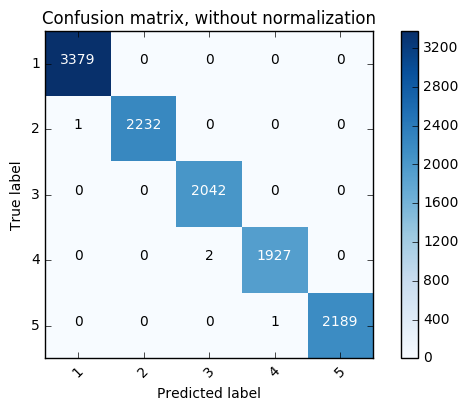

In [8]:
import itertools
import numpy as np
import matplotlib.pyplot as plt

from sklearn import svm, datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

class_names = [1, 2, 3, 4, 5]

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, pred)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')

#Turn off gridlines
ax = plt.gca()
ax.grid(False)

plt.show()

## Performance - Precision & Recall

*Precision*: When a label is predicted, the precision is the fraction of times that label is correct.

*Recall*: For a given exercise, the recall is the fraction of times the classifier predicted that exercise.

In [9]:
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score

precision = precision_score(y_test, pred, average='macro')
recall = recall_score(y_test, pred, average='macro')

print("Precision:", "{:0.2%}".format(precision))
print("\nRecall:", "{:0.2%}".format(recall))

#F1 score - weighted average of precision/recall
f1 = f1_score(y_test, pred, average='macro')
print("\nf1:", "{:0.2%}".format(f1))

Precision: 99.96%

Recall: 99.96%

f1: 99.96%


## Now using Random Forest Classifier determined by quick model selection

In [13]:
#Maximize class seperability via LDA
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import NearestNeighbors
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB

#Select model based on best base performance using CV
mlpc = MLPClassifier()
rf2 = RandomForestClassifier()
naive = GaussianNB()

#Train all
mlpcModel = mlpc.fit(X_train, y_train)
rf2Model = rf2.fit(X_train, y_train)
naiveModel = naive.fit(X_train, y_train)

#Test base performance
print("MLPC CV:", "{:.2%}".format(cross_val_score(mlpcModel, X_test, y_test).mean()))
print("RF CV:", "{:.2%}".format(cross_val_score(rf2Model, X_test, y_test).mean()))
print("NAIVE CV:", "{:.2%}".format(cross_val_score(naiveModel, X_test, y_test).mean()))

#Did hyperparameter tuning for maximum accuracy
rf = RandomForestClassifier(n_estimators=70, max_depth=None, min_samples_split=4, random_state=0)
rfModel = rf.fit(X_train, y_train)
scores = cross_val_score(rfModel, X_test, y_test)
print("\n New RF CrossValidated score:", "{:0.2%}".format(scores.mean()))
pred2 = rfModel.predict(X_test)
acc2 = accuracy_score(y_test, pred2)
print("Assessing generalization using the test set: ", "{:0.2%}".format(acc2))

MLPC CV: 84.43%
RF CV: 98.55%
NAIVE CV: 54.47%

 New RF CrossValidated score: 99.27%
Assessing generalization using the test set:  99.93%


## Performance - Compute and show confusion matrix

Confusion matrix, without normalization
[[3379    0    0    0    0]
 [   3 2230    0    0    0]
 [   0    2 2040    0    0]
 [   0    0    2 1927    0]
 [   0    0    0    1 2189]]


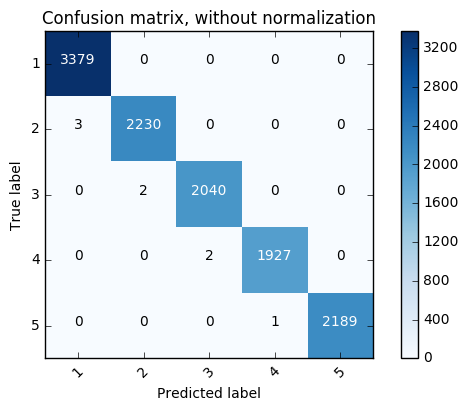

In [14]:
# Compute confusion matrix
cnf_matrix2 = confusion_matrix(y_test, pred2)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix2, classes=class_names,
                      title='Confusion matrix, without normalization')

#Turn off gridlines
ax = plt.gca()
ax.grid(False)

plt.show()

In [15]:
precision2 = precision_score(y_test, pred2, average='macro')
recall2 = recall_score(y_test, pred2, average='macro')

print("Precision:", "{:0.2%}".format(precision2))
print("\nRecall:", "{:0.2%}".format(recall2))

#F1 score - weighted average of precision/recall
f12 = f1_score(y_test, pred2, average='macro')
print("\nf1:", "{:0.2%}".format(f12))

Precision: 99.93%

Recall: 99.92%

f1: 99.93%


## Difference between TPOT generated model and my own

In [16]:
#Difference in Precision
precisionDif = precision - precision2
print("Precision difference:", "{:0.2%}".format(precisionDif))
print("Equivalent to", math.floor(precisionDif * len(y_test)), "samples from the test set")

#Difference in Recall
recallDif = recall - recall2
print("\nPrecision difference:", "{:0.2%}".format(recallDif))
print("Equivalent to", math.floor(recallDif * len(y_test)), "samples from the test set")

#Difference in f1
f1Dif = f1 - f12
print("\nPrecision difference:", "{:0.2%}".format(f1Dif))
print("Equivalent to", math.floor(f1Dif * len(y_test)), "samples from the test set")

Precision difference: 0.03%
Equivalent to 3 samples from the test set

Precision difference: 0.04%
Equivalent to 4 samples from the test set

Precision difference: 0.03%
Equivalent to 3 samples from the test set


## A motivation for not having 100% accuracy
If we use LDA to perform a transformation that preserves the most class separation, we could see how closely each exercise is related to each other, or in other words, which incorrect exercises are similar to each other.

CV score on LDA transformed data: 70.58%
Confusion matrix, without normalization
[[2869  134  135  183   58]
 [ 246 1464  343   78  102]
 [ 123  132 1661   46   80]
 [ 222  136  247 1238   86]
 [ 161  175  245  107 1502]]


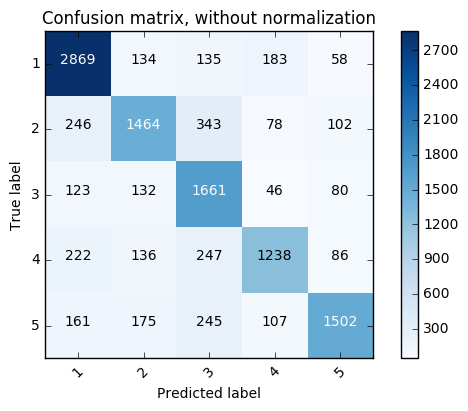

In [17]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

lda = LinearDiscriminantAnalysis(solver='eigen', shrinkage=0.8, n_components=4)
ldaModel = lda.fit(X_train, y_train)

#Transform the data before inputting to the Gradient boosting classifier
X_train_transformed = ldaModel.transform(X_train)
X_test_transformed = ldaModel.transform(X_test)

#train better model on transformed data
tpotModel.fit(X_train_transformed, y_train)
scores = cross_val_score(tpotModel, X_test_transformed, y_test)
print("CV score on LDA transformed data:", "{:.2%}".format(scores.mean()))

#See generalization
pred3 = tpotModel.predict(X_test_transformed)
acc3 = accuracy_score(y_test, pred3)

#Compute Confusion Matrix
cnf_matrix3 = confusion_matrix(y_test, pred3)
np.set_printoptions(precision=2)

#Show Confusion Matrix
plt.figure()
plot_confusion_matrix(cnf_matrix3, classes=class_names,
                      title='Confusion matrix, without normalization')

#Turn off gridlines
ax = plt.gca()
ax.grid(False)

plt.show()

In [ ]:
sc.stop()